In [6]:
!ls

crackDetection.ipynb  README.md  trainingData


In [2]:
! git clone https://github.com/chaurasiat/crackDetection.git


Cloning into 'crackDetection'...
remote: Counting objects: 65, done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 65 (delta 41), reused 62 (delta 41), pack-reused 0
Unpacking objects: 100% (65/65), done.


In [0]:
import os
os.chdir("crackDetection")

In [0]:
import csv
import matplotlib.image as mpimg
import cv2
import numpy as np
import os
import logging
import glob

In [8]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Activation, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.model_selection import train_test_split
import sklearn

Using TensorFlow backend.


In [0]:
width = 58
height = 58

In [13]:
crack   = glob.glob('trainingData/Crack/*.JPG') 
nonCrack   = glob.glob('trainingData/NonCrack/*.JPG')

print(len(Crack), len(NonCrack))

(29, 24)


In [0]:
img_size=64
def show3img(img, img1, img2):
   plt.figure(figsize=(6, 2))
   plt.subplot(1, 3, 1)
   plt.imshow(img)
   plt.title("Raw image")
   plt.subplot(1, 3, 2)
   plt.imshow(img1)
   plt.title("Processed image")
   plt.subplot(1, 3, 3)
   plt.imshow(img2)
   plt.title("Augmented image")
   plt.show()
   
def eq_Hist(img):
   #Histogram Equalization
   img2=img.copy()
   img2[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
   img2[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
   img2[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
   return img2

def scale_img(img):
   img2=img.copy()
   sc_y=0.4*np.random.rand()+1.0
   img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
   c_x,c_y, sh = int(img2.shape[0]/2), int(img2.shape[1]/2), int(img_size/2)
   return img2

def crop(img, mar=0):
   c_x,c_y, sh = int(img.shape[0]/2), int(img.shape[1]/2), int(img_size/2-mar)
   return img[(c_x-sh):(c_x+sh),(c_y-sh):(c_y+sh)]

def rotate_img(img):
   c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
   ang = 30.0*np.random.rand()-15
   Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
   return cv2.warpAffine(img, Mat, img.shape[:2])

def sharpen_img(img):
   gb = cv2.GaussianBlur(img, (7,7), 20.0)
   return cv2.addWeighted(img, 2, gb, -1, 0)
#Compute linear image transformation ing*s+m
def lin_img(img,s=1.0,m=0.0):
   img2=cv2.multiply(img, np.array([s]))
   return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
   m=127.0*(1.0-s)
   return lin_img(img, s, m)

def transform_img(img):
   img2=sharpen_img(img)
   img2=crop(img2,3)
   img2=contr_img(img2, 1.5)
   return eq_Hist(img2)

def augment_img(img):
   img=contr_img(img, 1.8*np.random.rand()+0.2)
   img=rotate_img(img)
   img=scale_img(img)
   return transform_img(img)

def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst
def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst


In [14]:
X_train_aug_crack = []
y_train_aug = []
for i in range(len(crack)):
     img=mpimg.imread(crack[i])
     img=cv2.resize(img, (58, 58))
     X_train_aug_crack.append(img)
     y_train_aug.append(1)
     img = cv2.flip(img,1)
     X_train_aug_crack.append(img)
     y_train_aug.append(1)
     img = rotate_img(img)
     X_train_aug_crack.append(img)
     y_train_aug.append(1)
#      img=random_warp(img)
#      X_train_aug_roots.append(img)
#      y_train_aug.append(1)
#      img=random_brightness(img)
#      X_train_aug_roots.append(img)
#      y_train_aug.append(1)
    


for i in range(len(nonCrack)):
     img=mpimg.imread(nonCrack[i])
     img=cv2.resize(img, (58, 58))
     X_train_aug_crack.append(img)
     y_train_aug.append(0)
     img = cv2.flip(img,1)
     X_train_aug_crack.append(img)
     y_train_aug.append(0)
     img = rotate_img(img)
     X_train_aug_crack.append(img)
     y_train_aug.append(0)
#      img=random_warp(img)
#      X_train_aug_roots.append(img)
#      y_train_aug.append(0)
#      img=random_brightness(img)
#      X_train_aug_roots.append(img)
#      y_train_aug.append(0)
     

   
print("Total number of images in the augmented dataset = ", len(X_train_aug_crack))  
print(len(y_train_aug))

('Total number of images in the augmented dataset = ', 159)
159


In [0]:
activation = 'relu'
dropout = 1

def model(dshape):
    
    seq_model = Sequential()

    seq_model.add(BatchNormalization(input_shape=(dshape[0], dshape[1], dshape[2])))
    seq_model.add(Conv2D(24, (5, 5), padding='valid',
                  activation=activation, strides=(2, 2)))

    seq_model.add(Conv2D(36, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(48, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.5))
    seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Dropout(0.4))
    #seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Flatten())
    seq_model.add(Dropout(0.6))
    seq_model.add(Dense(100, activation=activation))
    seq_model.add(Dropout(0.2))
    seq_model.add(Dense(50, activation=activation))
    seq_model.add(Dropout(0.3))
    seq_model.add(Dense(10, activation=activation))
    seq_model.add(Dense(1, activation='sigmoid'))
    seq_model.compile(loss='binary_crossentropy', optimizer=adam(), metrics=['accuracy'])
    seq_model.summary()

    return seq_model

In [0]:
from sklearn.utils import shuffle
from keras.utils.data_utils import Sequence

images, labels = shuffle(X_train_aug_crack, y_train_aug)

In [17]:
images = np.asarray(images)
labels = np.asarray(labels)
print(images.dtype, images.shape)
print(type(images))
print(labels)

(dtype('uint8'), (159, 58, 58, 3))
<type 'numpy.ndarray'>
[0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 0 0 1
 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0
 1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0
 0 1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1
 1 0 0 1 1 0 1 0 1 0 0]


In [18]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import adam
#from keras.utils.data_utils import Sequence

keras_model = model((height, width, 3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 58, 58, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 36)        21636     
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 48)          43248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 48)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          27712     
__________

In [19]:
keras_model.fit(images, labels, epochs=100, batch_size=32, verbose=1, shuffle=True, validation_split=0.15)

Train on 135 samples, validate on 24 samples
Epoch 1/100
135/135 [==============================] - 1s 9ms/step - loss: 0.7229 - acc: 0.5111 - val_loss: 0.6649 - val_acc: 0.5833
Epoch 2/100
135/135 [==============================] - 0s 4ms/step - loss: 0.6854 - acc: 0.5481 - val_loss: 0.6442 - val_acc: 0.5833
Epoch 3/100
135/135 [==============================] - 0s 4ms/step - loss: 0.7210 - acc: 0.5481 - val_loss: 0.6569 - val_acc: 0.6250
Epoch 4/100
135/135 [==============================] - 0s 4ms/step - loss: 0.6982 - acc: 0.5111 - val_loss: 0.6647 - val_acc: 0.7083
Epoch 5/100
135/135 [==============================] - 0s 4ms/step - loss: 0.7116 - acc: 0.5185 - val_loss: 0.6742 - val_acc: 0.7500
Epoch 6/100
135/135 [==============================] - 0s 4ms/step - loss: 0.6644 - acc: 0.5407 - val_loss: 0.6712 - val_acc: 0.6250
Epoch 7/100
135/135 [==============================] - 0s 4ms/step - loss: 0.6684 - acc: 0.5630 - val_loss: 0.6620 - val_acc: 0.6250
Epoch 8/100
135/135 [===

135/135 [==============================] - 0s 4ms/step - loss: 0.5134 - acc: 0.7111 - val_loss: 0.4868 - val_acc: 0.8750
Epoch 17/100
135/135 [==============================] - 0s 4ms/step - loss: 0.4894 - acc: 0.7037 - val_loss: 0.4967 - val_acc: 0.9167
Epoch 18/100
135/135 [==============================] - 0s 4ms/step - loss: 0.4894 - acc: 0.8444 - val_loss: 0.5049 - val_acc: 0.8333
Epoch 19/100
135/135 [==============================] - 0s 4ms/step - loss: 0.4890 - acc: 0.8148 - val_loss: 0.5156 - val_acc: 0.9167
Epoch 20/100
135/135 [==============================] - 0s 4ms/step - loss: 0.4667 - acc: 0.8222 - val_loss: 0.4952 - val_acc: 0.8750
Epoch 21/100
135/135 [==============================] - 1s 4ms/step - loss: 0.4694 - acc: 0.8370 - val_loss: 0.5052 - val_acc: 0.9167
Epoch 22/100
135/135 [==============================] - 0s 4ms/step - loss: 0.4516 - acc: 0.9111 - val_loss: 0.4839 - val_acc: 0.8750
Epoch 23/100
135/135 [==============================] - 0s 4ms/step - loss:

135/135 [==============================] - 0s 4ms/step - loss: 0.3878 - acc: 0.8593 - val_loss: 0.4550 - val_acc: 0.8333
Epoch 32/100
135/135 [==============================] - 0s 4ms/step - loss: 0.3479 - acc: 0.8889 - val_loss: 0.4567 - val_acc: 0.7917
Epoch 33/100
135/135 [==============================] - 0s 4ms/step - loss: 0.3656 - acc: 0.9111 - val_loss: 0.4510 - val_acc: 0.8333
Epoch 34/100
135/135 [==============================] - 0s 4ms/step - loss: 0.3528 - acc: 0.8815 - val_loss: 0.4337 - val_acc: 0.7917
Epoch 35/100
135/135 [==============================] - 0s 4ms/step - loss: 0.2949 - acc: 0.9481 - val_loss: 0.3157 - val_acc: 0.9167
Epoch 36/100
135/135 [==============================] - 0s 4ms/step - loss: 0.3333 - acc: 0.8815 - val_loss: 0.3529 - val_acc: 0.8333
Epoch 37/100
135/135 [==============================] - 0s 4ms/step - loss: 0.2788 - acc: 0.9407 - val_loss: 0.3297 - val_acc: 0.8750
Epoch 38/100
135/135 [==============================] - 0s 4ms/step - loss:

135/135 [==============================] - 0s 4ms/step - loss: 0.2314 - acc: 0.9259 - val_loss: 0.2768 - val_acc: 0.9167
Epoch 47/100
135/135 [==============================] - 0s 4ms/step - loss: 0.2090 - acc: 0.9333 - val_loss: 0.2317 - val_acc: 0.8750
Epoch 48/100
135/135 [==============================] - 0s 4ms/step - loss: 0.3407 - acc: 0.9037 - val_loss: 0.3604 - val_acc: 0.8333
Epoch 49/100
135/135 [==============================] - 0s 4ms/step - loss: 0.2131 - acc: 0.9111 - val_loss: 0.2626 - val_acc: 0.9167
Epoch 50/100
135/135 [==============================] - 0s 4ms/step - loss: 0.2581 - acc: 0.8963 - val_loss: 0.1244 - val_acc: 1.0000
Epoch 51/100
135/135 [==============================] - 0s 4ms/step - loss: 0.1812 - acc: 0.9185 - val_loss: 0.2550 - val_acc: 0.8750
Epoch 52/100
135/135 [==============================] - 0s 4ms/step - loss: 0.1652 - acc: 0.9407 - val_loss: 0.3585 - val_acc: 0.8750
Epoch 53/100
135/135 [==============================] - 0s 4ms/step - loss:

135/135 [==============================] - 0s 4ms/step - loss: 0.1557 - acc: 0.9556 - val_loss: 0.0918 - val_acc: 0.9583
Epoch 62/100
135/135 [==============================] - 0s 4ms/step - loss: 0.0882 - acc: 0.9778 - val_loss: 0.1669 - val_acc: 0.9167
Epoch 63/100
135/135 [==============================] - 0s 4ms/step - loss: 0.0941 - acc: 0.9852 - val_loss: 0.0931 - val_acc: 0.9583
Epoch 64/100
135/135 [==============================] - 0s 4ms/step - loss: 0.2234 - acc: 0.9333 - val_loss: 0.1522 - val_acc: 0.9583
Epoch 65/100
135/135 [==============================] - 1s 4ms/step - loss: 0.1519 - acc: 0.9407 - val_loss: 0.6185 - val_acc: 0.7083
Epoch 66/100
135/135 [==============================] - 0s 4ms/step - loss: 0.2676 - acc: 0.8963 - val_loss: 0.3731 - val_acc: 0.8333
Epoch 67/100
135/135 [==============================] - 0s 4ms/step - loss: 0.3205 - acc: 0.8519 - val_loss: 0.2706 - val_acc: 0.8750
Epoch 68/100
135/135 [==============================] - 0s 4ms/step - loss:

135/135 [==============================] - 0s 4ms/step - loss: 0.0791 - acc: 0.9778 - val_loss: 0.1399 - val_acc: 0.9583
Epoch 77/100
135/135 [==============================] - 0s 4ms/step - loss: 0.0724 - acc: 0.9852 - val_loss: 0.1749 - val_acc: 0.9167
Epoch 78/100
135/135 [==============================] - 0s 4ms/step - loss: 0.0821 - acc: 0.9630 - val_loss: 0.0612 - val_acc: 1.0000
Epoch 79/100
135/135 [==============================] - 0s 4ms/step - loss: 0.0752 - acc: 0.9778 - val_loss: 0.0844 - val_acc: 1.0000
Epoch 80/100
135/135 [==============================] - 0s 4ms/step - loss: 0.0996 - acc: 0.9704 - val_loss: 0.1934 - val_acc: 0.9167
Epoch 81/100
135/135 [==============================] - 0s 4ms/step - loss: 0.1609 - acc: 0.9333 - val_loss: 0.1230 - val_acc: 0.9583
Epoch 82/100
135/135 [==============================] - 0s 4ms/step - loss: 0.0507 - acc: 0.9852 - val_loss: 0.1342 - val_acc: 0.9167
Epoch 83/100
135/135 [==============================] - 0s 4ms/step - loss:

135/135 [==============================] - 0s 4ms/step - loss: 0.1342 - acc: 0.9556 - val_loss: 0.2518 - val_acc: 0.9167
Epoch 92/100
135/135 [==============================] - 0s 4ms/step - loss: 0.1000 - acc: 0.9481 - val_loss: 0.5269 - val_acc: 0.7917
Epoch 93/100
135/135 [==============================] - 0s 4ms/step - loss: 0.1087 - acc: 0.9630 - val_loss: 0.6479 - val_acc: 0.7500
Epoch 94/100
135/135 [==============================] - 0s 4ms/step - loss: 0.1129 - acc: 0.9704 - val_loss: 0.8361 - val_acc: 0.7500
Epoch 95/100
135/135 [==============================] - 0s 4ms/step - loss: 0.1603 - acc: 0.9259 - val_loss: 0.2563 - val_acc: 0.9167
Epoch 96/100
135/135 [==============================] - 0s 4ms/step - loss: 0.1510 - acc: 0.9407 - val_loss: 0.6391 - val_acc: 0.8333
Epoch 97/100
135/135 [==============================] - 0s 4ms/step - loss: 0.1246 - acc: 0.9704 - val_loss: 0.2387 - val_acc: 0.8750
Epoch 98/100
135/135 [==============================] - 0s 4ms/step - loss:

In [0]:
def  save_keras_model (save_model, path):
    """Save keras model to given path."""
    save_model.save_weights(path + 'model.h5')

    with open(path + 'model.json', "w") as text_file:
        text_file.write(save_model.to_json())

    logging.info('Keras json model saved. %s', path + 'model.json')
    logging.info('Keras h5 model saved. %s', path + 'model.h5')

In [0]:
save_keras_model(keras_model, 'keras')

In [0]:
from keras.models import model_from_json
model_path = 'kerasmodel'

inf_model = model_from_json(open(model_path + '.json','r').read())
inf_model.load_weights(model_path + '.h5')

In [24]:
im = mpimg.imread( "trainingData/NonCrack/Capture1.JPG")
im = cv2.resize(im,(58,58))
print( round(inf_model.predict(np.expand_dims(im, 0))[0, 0]))

0.0


In [0]:
def find_roots(img, ystart, ystop, scale, pix_per_cell,cell_per_block):#, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins):
    
    boxes=[]
  
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
#     ctrans_tosearch = hp.convert_color(img_tosearch, conv=color_space)
    ctrans_tosearch = img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
#     nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    print(nxsteps)
    
#     # Compute individual channel HOG features for the entire image
#     hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
           
#             hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (58,58))
#             plt.imshow(subimg)
#             plt.show
            # Get color features
#             spatial_features = hp.bin_spatial(subimg, size=spatial_size)
#             hist_features = hp.color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#             test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))  
            test_prediction = round(inf_model.predict(np.expand_dims(subimg, 0))[0, 0])
#             print(test_prediction)
#             test_prediction = svc.predict(test_features)
            
            if test_prediction == 1.0:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))#,(0,0,255),6)) 
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return boxes

In [0]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    for box in bboxes:
        cv2.rectangle(draw_img,box[0],box[1],color,thick)
    
    return draw_img # Change this line to return image copy with boxes

['trainingData/Crack/Capture19.JPG']
trainingData/Crack/Capture19.JPG
1


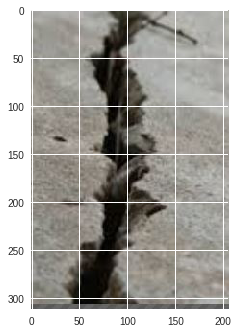

In [33]:
import matplotlib.pyplot as plt
ystart = 30
ystop = 50
scale = 3
pix_per_cell=8
cell_per_block=2
test_images=glob.glob('trainingData/Crack/Capture19.JPG')
print(test_images)
for fname in test_images:
    print(fname)
    test_img=mpimg.imread(fname)
    plt.imshow(test_img)
    #plt.subplot(6,1,i)
    boxes=find_roots(test_img, ystart, ystop, scale, pix_per_cell,cell_per_block ) #, clf, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins)
    #print(boxes[0][0])
    test_out_img=draw_boxes(test_img,boxes)
    plt.imshow(test_out_img)
    plt.show()